NLA assignment
----

This Code was done as part of Durham University's Summative Assessment for the subject of Natural Language Analysis.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from transformers import AutoTokenizer, AutoModel, pipeline, AutoModelForCausalLM

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Load & Merge Data

In [3]:
bodies = pd.read_csv('bodies.csv')
stances = pd.read_csv('stances.csv')

In [4]:
stances

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
...,...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,1681,unrelated
49968,Brian Williams slams social media for speculat...,2419,unrelated
49969,Mexico Says Missing Students Not Found In Firs...,1156,agree
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,1012,discuss


In [5]:
bodies

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
...,...,...
1678,2528,Intelligence agencies hunting for identity of ...
1679,2529,"While Daleks ""know no fear"" and ""must not fear..."
1680,2530,More than 200 schoolgirls were kidnapped in Ap...
1681,2531,A Guantanamo Bay prisoner released last year a...


In [7]:
joint = pd.merge(stances, bodies, on="Body ID", how="left")

In [10]:
df= joint
df

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."
...,...,...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,1681,unrelated,(CNN) -- Boko Haram laughed off Nigeria's anno...
49968,Brian Williams slams social media for speculat...,2419,unrelated,Along with unveiling the Apple Watch earlier t...
49969,Mexico Says Missing Students Not Found In Firs...,1156,agree,The bodies found in a mass grave were confirme...
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,1012,discuss,Rep. Duncan Hunter (R-CA) told Greta Van Suste...


In [12]:
bodies[bodies["Body ID"]==712]

,Body ID,articleBody
475,712,Danny Boyle is directing the untitled film\n\n...


In [13]:
joint.isnull().sum()

Headline       0
Body ID        0
Stance         0
articleBody    0
dtype: int64

In [14]:
joint['Body ID'].unique()

array([ 712,  158,  137, ...,  915,  407, 1066], dtype=int64)

In [15]:
joint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     49972 non-null  object
 1   Body ID      49972 non-null  int64 
 2   Stance       49972 non-null  object
 3   articleBody  49972 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [16]:
joint['Stance'].value_counts()

Stance
unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: count, dtype: int64

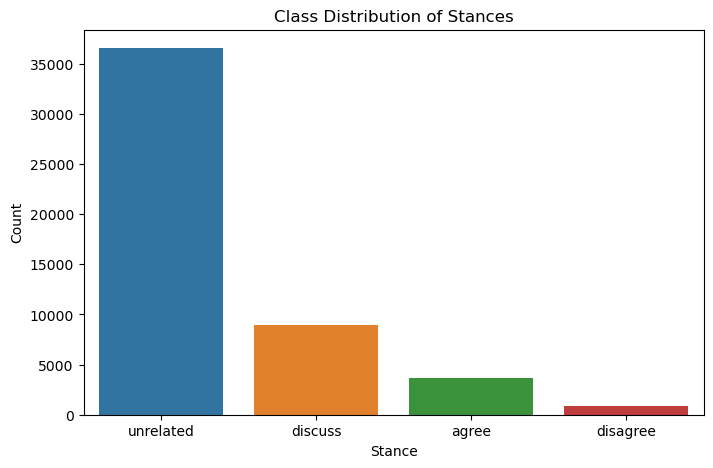

In [21]:
#Visualising imbalance
plt.figure(figsize=(8,5))
sns.countplot(data = joint, x = 'Stance', order = joint['Stance'].value_counts().index)
plt.title("Class Distribution of Stances")
plt.xlabel("Stance")
plt.ylabel("Count")
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Selecting features
x= joint[['Headline', 'articleBody']]

#labels
y= joint['Stance']

#splitting data
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.3, random_state=42)

#combining headlines and articlebody into a single string for modeling
x_train_combined = x_train['Headline'] + " " + x_train['articleBody']

#Oversampleing the training set
ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x_train_combined.to_frame(), y_train)
x_resampled.columns = ['text']

In [23]:
y_resampled.value_counts()

Stance
discuss      25581
unrelated    25581
agree        25581
disagree     25581
Name: count, dtype: int64

In [24]:
#multi-class Classification

#TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features = 10000, stop_words = 'english')
x_train_tfidf = vectorizer.fit_transform(x_resampled.squeeze())

#Prepare the test set (combine headline + article body)
x_test_combined = x_test['Headline'] + " " + x_test['articleBody']
x_test_tfidf = vectorizer.transform(x_test_combined)

In [27]:
# Training logistic regression model
clf = RandomForestClassifier(n_estimators=200, class_weight='balanced',  random_state=42, n_jobs=-1)
clf.fit(x_train_tfidf, y_resampled)

# Predicting on the test set
y_pred = clf.predict(x_test_tfidf)

print("\n Classification Report: \n")
print(classification_report(y_test, y_pred))


 Classification Report: 

              precision    recall  f1-score   support

       agree       0.65      0.63      0.64      1103
    disagree       0.40      0.37      0.38       252
     discuss       0.81      0.82      0.81      2673
   unrelated       0.97      0.97      0.97     10964

    accuracy                           0.91     14992
   macro avg       0.71      0.70      0.70     14992
weighted avg       0.91      0.91      0.91     14992



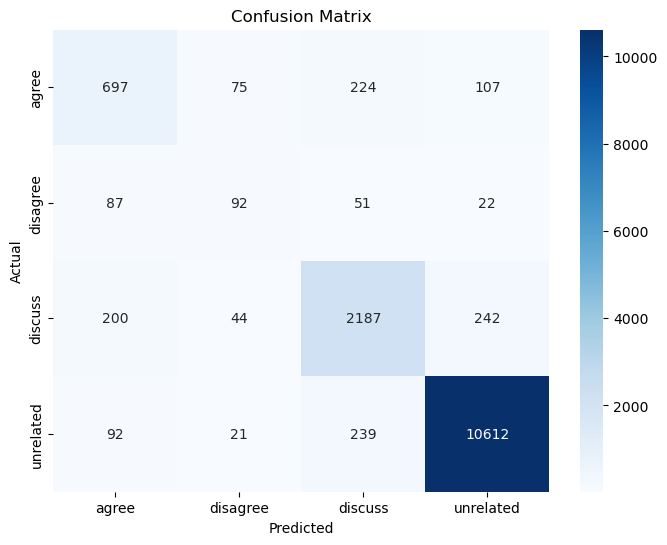

In [31]:
labels = clf.classes_
cm = confusion_matrix(y_test,y_pred, labels = labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot= True, fmt='d', cmap='Blues', xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [32]:
#binary Classification
def map_to_binary(label):
    return "Related" if label in ["agree", "disagree", "discuss"] else "Unrelated"

# Apply to y_resampled and y_test
y_resampled_binary = y_resampled.apply(map_to_binary)
y_test_binary = y_test.apply(map_to_binary)

# Optional: Check class distribution
print("Train label distribution:\n", y_resampled_binary.value_counts())
print("\nTest label distribution:\n", y_test_binary.value_counts())

Train label distribution:
 Stance
Related      76743
Unrelated    25581
Name: count, dtype: int64

Test label distribution:
 Stance
Unrelated    10964
Related       4028
Name: count, dtype: int64


In [33]:
clf_binary = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
clf_binary.fit(x_train_tfidf, y_resampled_binary)

y_pred_binary = clf_binary.predict(x_test_tfidf)
print(classification_report(y_test_binary, y_pred_binary))

              precision    recall  f1-score   support

     Related       0.92      0.92      0.92      4028
   Unrelated       0.97      0.97      0.97     10964

    accuracy                           0.96     14992
   macro avg       0.94      0.95      0.95     14992
weighted avg       0.96      0.96      0.96     14992



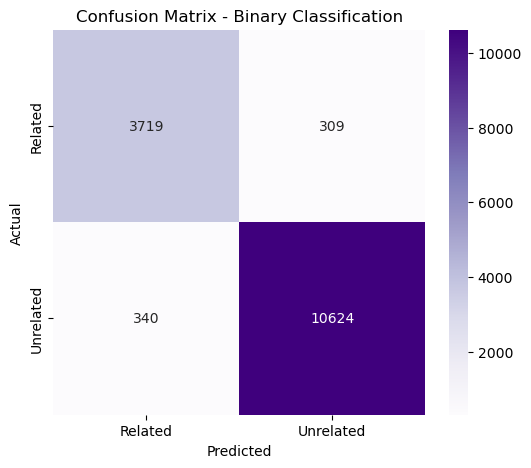

In [34]:
labels_binary = clf_binary.classes_
cm_binary = confusion_matrix(y_test_binary, y_pred_binary, labels=labels_binary)

plt.figure(figsize=(6,5))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Purples', xticklabels=labels_binary, yticklabels=labels_binary)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Binary Classification")
plt.show()

## 3. Preprocessing & Labels

In [3]:
df['text'] = df['Headline'] + ' ' + df['articleBody']
df['binary'] = (df['Stance'] != 'unrelated').astype(int)
df['fourway'] = df['Stance']
print(df['binary'].value_counts(normalize=True))
print(df['fourway'].value_counts(normalize=True))

binary
0    0.73131
1    0.26869
Name: proportion, dtype: float64
fourway
unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: proportion, dtype: float64


## 4. TF-IDF + Logistic Regression (Binary)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# — Stratified “sampling” of 10k rows —
# split the full index into 10k train‐idx and the rest (we discard the rest)
sample_idx, _ = train_test_split(
    df.index,
    train_size=10000,
    random_state=42,
    stratify=df['binary']
)
sample_df = df.loc[sample_idx]

# — Split into train/test —
X = sample_df['text']
y = sample_df['binary']
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# — TF-IDF vectorization —
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
Xtr = tfidf.fit_transform(X_tr)
Xte = tfidf.transform(X_te)

# — Hyperparameter search for Logistic Regression —
param_grid = {'C': [0.01, 0.1, 1, 10]}
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
gs = GridSearchCV(lr, param_grid, cv=3, scoring='f1', n_jobs=-1)
gs.fit(Xtr, y_tr)
print("Best C:", gs.best_params_)

# — Evaluate on test set —
y_pred = gs.predict(Xte)
print(classification_report(y_te, y_pred))
print("Accuracy:", accuracy_score(y_te, y_pred))


Best C: {'C': 10}
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1463
           1       0.55      0.65      0.60       537

    accuracy                           0.77      2000
   macro avg       0.71      0.73      0.72      2000
weighted avg       0.78      0.77      0.77      2000

Accuracy: 0.765


## 5. TF-IDF + SVM (4-way)

In [6]:
X4 = sample_df['text']; y4 = sample_df['fourway']
X4_tr, X4_te, y4_tr, y4_te = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)
X4tr = tfidf.fit_transform(X4_tr)
X4te = tfidf.transform(X4_te)
svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X4tr, y4_tr)
y4_pred = svm.predict(X4te)
print(classification_report(y4_te, y4_pred))

              precision    recall  f1-score   support

       agree       0.20      0.51      0.29       141
    disagree       0.15      0.54      0.23        35
     discuss       0.40      0.69      0.51       361
   unrelated       0.90      0.55      0.68      1463

    accuracy                           0.57      2000
   macro avg       0.41      0.57      0.43      2000
weighted avg       0.74      0.57      0.61      2000



## 6. Transformer Embeddings + LR (Binary)

In [8]:
# Load BERT
from sklearn.model_selection import train_test_split

tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-uncased')
model_bert     = AutoModel.from_pretrained('bert-base-uncased')
model_bert.eval()

def get_cls_embeddings(texts, batch_size=16):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokens = tokenizer_bert(batch,
                                padding=True,
                                truncation=True,
                                return_tensors='pt')
        with torch.no_grad():
            out = model_bert(**tokens)
        embs.append(out.last_hidden_state[:,0,:].cpu().numpy())
    return np.vstack(embs)

# ─── Stratified “sampling” of 2,000 rows ───────────────────────────
sample_idx, _ = train_test_split(
    df.index,
    train_size=2000,
    random_state=42,
    stratify=df['binary']
)
small = df.loc[sample_idx]

# ─── Compute embeddings ────────────────────────────────────────────
texts = small['text'].tolist()
embs  = get_cls_embeddings(texts)

# ─── Split embeddings into train/test ─────────────────────────────
y_small = small['binary'].values
X_tr_e, X_te_e, y_tr_e, y_te_e = train_test_split(
    embs,
    y_small,
    test_size=0.2,
    random_state=42,
    stratify=y_small
)

# ─── Train Logistic Regression ────────────────────────────────────
lr_e = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_e.fit(X_tr_e, y_tr_e)

# ─── Evaluate ─────────────────────────────────────────────────────
y_pred_e = lr_e.predict(X_te_e)
print(classification_report(y_te_e, y_pred_e))
print('Embedding-based accuracy:', accuracy_score(y_te_e, y_pred_e))


              precision    recall  f1-score   support

           0       0.85      0.84      0.85       293
           1       0.58      0.59      0.58       107

    accuracy                           0.78       400
   macro avg       0.71      0.72      0.71       400
weighted avg       0.78      0.78      0.78       400

Embedding-based accuracy: 0.775


## 7. Zero-Shot Classification (BART-MNLI)

In [9]:
zs = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
labels=['Related','Unrelated']
y_pred_zs=[]
for txt in tqdm(X_te, desc='Zero-Shot'):
    out=zs(txt,labels)
    y_pred_zs.append(1 if out['labels'][0]=='Related' else 0)
print(classification_report(y_te,y_pred_zs))
print('ZS acc:', accuracy_score(y_te,y_pred_zs))

Zero-Shot: 100%|██████████| 2000/2000 [1:29:23<00:00,  2.68s/it]  

              precision    recall  f1-score   support

           0       0.69      0.01      0.03      1463
           1       0.27      0.98      0.42       537

    accuracy                           0.27      2000
   macro avg       0.48      0.50      0.22      2000
weighted avg       0.58      0.27      0.13      2000

ZS acc: 0.274


## 8. Few-Shot Classification (Generative)

In [ ]:
# Few‐Shot Classification (Generative GPT-2) — Fixed

# %% 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.auto import tqdm

# 1) Load & configure GPT-2 for padding
gen_tok   = AutoTokenizer.from_pretrained('gpt2')
gen_model = AutoModelForCausalLM.from_pretrained('gpt2')
# Tell it explicitly what pad_token is:
gen_tok.pad_token = gen_tok.eos_token
gen_model.config.pad_token_id = gen_tok.eos_token_id

# 2) Build a stratified 1,000-row subset
idx1k, _ = train_test_split(
    df.index,
    train_size=1000,
    random_state=42,
    stratify=df['binary']
)
df1k = df.loc[idx1k]
train_fs, test_fs = train_test_split(
    df1k,
    test_size=0.2,
    random_state=42,
    stratify=df1k['binary']
)

# 3) Pick 3 few-shot examples (no stratify here)
few_examples = train_fs.sample(n=3, random_state=1)

# Reserve 10 tokens for generation
RESERVE = 10
MAX_INPUT = gen_model.config.n_positions - RESERVE

def few_shot_predict(headline, body, examples):
    # a) Build the prompt
    prompt = ""
    for _, ex in examples.iterrows():
        lbl = "Related" if ex['binary'] else "Unrelated"
        prompt += (
            f"Headline: {ex['Headline']}\n"
            f"Body: {ex['articleBody']}\n"
            f"Stance: {lbl}\n"
            f"---\n"
        )
    prompt += f"Headline: {headline}\nBody: {body}\nStance:"

    # b) Tokenize & truncate **only** (no full-pad)
    inp = gen_tok(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=MAX_INPUT
    )

    # c) Generate exactly 5 new tokens
    out_ids = gen_model.generate(
        input_ids=inp.input_ids,
        attention_mask=inp.attention_mask,
        max_new_tokens=5,
        pad_token_id=gen_model.config.pad_token_id,
        eos_token_id=gen_model.config.eos_token_id,
    )[0]

    # d) Decode & extract after "Stance:"
    full = gen_tok.decode(out_ids, skip_special_tokens=True)
    answer = full.split("Stance:")[-1].strip().split("\n")[0]
    return answer

# 4) Run on test set
y_true, y_pred = [], []
for _, row in tqdm(test_fs.iterrows(), total=len(test_fs), desc="Few-Shot"):
    y_true.append(row['binary'])
    pred = few_shot_predict(row['Headline'], row['articleBody'], few_examples)
    y_pred.append(1 if pred == "Related" else 0)

# 5) Report
print("Few-Shot Generative Report:")
print(classification_report(y_true, y_pred))
print("Few-Shot Accuracy:", accuracy_score(y_true, y_pred))


Few-Shot: 100%|██████████| 200/200 [06:29<00:00,  1.95s/it]

Few-Shot Generative Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       146
           1       0.00      0.00      0.00        54

    accuracy                           0.73       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.53      0.73      0.62       200

Few-Shot Accuracy: 0.73



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

## 9. Chain-of-Thought Prompting (FLAN-T5)

In [ ]:

# 9. Chain‐of‐Thought Inspection & Evaluation in One Cell

# %%
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# 1) Load Flan-T5 and its tokenizer
tokenizer_cot = AutoTokenizer.from_pretrained('google/flan-t5-large')
model_cot     = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-large')
model_cot.eval()

# 2) Build a stratified test split (reuse your df with df['binary'] or df['fourway'])
#    Here we do binary (Related vs Unrelated)
idx2k, _   = train_test_split(df.index, train_size=2000, random_state=42, stratify=df['binary'])
df2k       = df.loc[idx2k]
_, test_cot = train_test_split(df2k, test_size=0.2, random_state=42, stratify=df2k['binary'])

# 3) Qualitative: print full CoT outputs for first 3 examples
print("=== Qualitative Chain‐of‐Thought Samples ===\n")
for _, row in test_cot.head(3).iterrows():
    prompt = (
        "You are an expert in text analysis. Think step-by-step:\n"
        "1) Is the article Related or Unrelated to the headline?\n"
        "2) If Related, is it Agree, Disagree, or Discuss?\n"
        f"Headline: {row['Headline']}\n"
        f"Body: {row['articleBody']}\n"
        "Answer:"
    )
    tokens = tokenizer_cot(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=512
    )
    out = model_cot.generate(
        **tokens,
        max_new_tokens=50,
        pad_token_id=tokenizer_cot.eos_token_id,
        eos_token_id=tokenizer_cot.eos_token_id
    )
    text = tokenizer_cot.decode(out[0], skip_special_tokens=True)
    print(text)
    print("-" * 80)

# 4) Quantitative: parse the final label and compute metrics
y_true, y_pred = [], []
for _, row in test_cot.iterrows():
    # regenerate prompt
    prompt = (
        "You are an expert in text analysis. Think step-by-step:\n"
        "1) Is the article Related or Unrelated to the headline?\n"
        "2) If Related, is it Agree, Disagree, or Discuss?\n"
        f"Headline: {row['Headline']}\n"
        f"Body: {row['articleBody']}\n"
        "Answer:"
    )
    tokens = tokenizer_cot(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=512
    )
    out = model_cot.generate(
        **tokens,
        max_new_tokens=50,
        pad_token_id=tokenizer_cot.eos_token_id,
        eos_token_id=tokenizer_cot.eos_token_id
    )
    text = tokenizer_cot.decode(out[0], skip_special_tokens=True)
    final_label = text.strip().split()[-1]  # assumes the last token is the label
    # map to binary or 4-way as appropriate
    y_true.append(row['binary'])  
    y_pred.append(1 if final_label.lower()=="related" else 0)

# 5) Print classification report
print("\n=== Quantitative CoT Evaluation ===")
print(classification_report(y_true, y_pred, target_names=["Unrelated","Related"]))
print("CoT Accuracy:", accuracy_score(y_true, y_pred))


=== Qualitative Chain‐of‐Thought Samples ===

Disagree
--------------------------------------------------------------------------------
Disagree
--------------------------------------------------------------------------------
Disagree
--------------------------------------------------------------------------------

=== Quantitative CoT Evaluation ===
              precision    recall  f1-score   support

   Unrelated       0.75      1.00      0.86       293
     Related       0.90      0.08      0.15       107

    accuracy                           0.75       400
   macro avg       0.82      0.54      0.50       400
weighted avg       0.79      0.75      0.67       400

CoT Accuracy: 0.7525
